# Univariate Density Estimation using Models Implemented in Python

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from pybmix.core.mixing import DirichletProcessMixing
from pybmix.core.hierarchy import PythonHierarchy
from pybmix.core.mixture_model import MixtureModel
from pybmix.estimators.density_estimator import DensityEstimator

In [63]:
np.random.seed(2021)

## Data Generation

We generate data from a two-component mixture model
$$
y_i \sim \frac{1}{2} \mathcal N(-3, 1) + \frac{1}{2} \mathcal N(3, 1), \quad i=1, \ldots, 200
$$

In [64]:
def sample_from_mixture(weights, means, sds, n_data):
    n_comp = len(weights)
    clus_alloc = np.random.choice(np.arange(n_comp), p=[0.5, 0.5], size=n_data)
    return np.random.normal(loc=means[clus_alloc], scale=sds[clus_alloc])

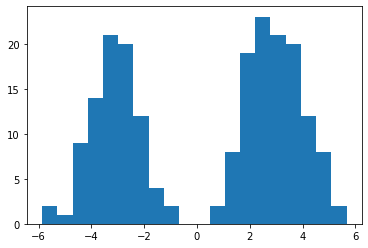

In [65]:
y = sample_from_mixture(
    np.array([0.5, 0.5]), np.array([-3, 3]), np.array([1, 1]), 200)
plt.hist(y, bins=20)
plt.show()

## The statistical model

We assume the following model

\begin{equation}
\begin{aligned}
y_i | \tilde{p} &\sim f(\cdot) = \int_{R \times R^+} \mathcal{Laplace}(\cdot | \mu, \lambda ) \tilde{p}(d\mu, d\lambda) \\
\tilde{p} &\sim DP(\alpha, G_0)
\end{aligned}
\end{equation}

Here, we assume that $\alpha = 5$ and $G_0(d\mu, d\lambda) = \mathcal N(d\mu | \mu_0, \sigma_0^2) \times IG(d\sigma^2 | \nu_0, \psi_0)$, i.e., $G_0$ is a normal-inverse gamma distribution.

"LapNIG_Hierarchy" is implemented in a .py file and here it is passed as argument to the generic PythonHierarchy object.

Below we compare the performances of Laplace-NIG and Normal-NIG models. Please refer to "Univariate Density Estimation via Dirichlet Process Mixture" for the mathematical description of the Normal-NIG model.

In [66]:
mixing = DirichletProcessMixing(total_mass=5)
hierarchy_lapnig = PythonHierarchy("LapNIG_Hierarchy")
hierarchy_nnig_ngg = PythonHierarchy("NNIG_Hierarchy_NGG")

In [67]:
mixture_lapnig = MixtureModel(mixing, hierarchy_lapnig)
mixture_nnig_ngg = MixtureModel(mixing, hierarchy_nnig_ngg)

In [68]:
niter = 1100
nburn = 100

In [69]:
mixture_lapnig.run_mcmc(y, algorithm="Neal8", niter=niter, nburn=nburn)

Initializing... Using hierarchy implementation in LapNIG_Hierarchy.py
Done
Running Neal8 algorithm (m=3 aux. blocks) with PythonHier hierarchies, DP mixing...
                                                         ] 3% 21.594s[==>                                                         ] 3% 22.442s[==>                                                         ] 3% 23.192s[==>                                                         ] 4% 24.027s[==>                                                         ] 4% 24.888s[==>                                                         ] 4% 25.827s[==>                                                         ] 4% 26.68s[==>                                                         ] 4% 27.454s[===>                                                        ] 5% 28.252s[===>                                                        ] 5% 29.12s[===>                                                        ] 5% 30.029s[===>                                       

In [70]:
mixture_nnig_ngg.run_mcmc(y, algorithm="Neal2", niter=niter, nburn=nburn)

Initializing... Using hierarchy implementation in NNIG_Hierarchy_NGG.py
Done
Running Neal2 algorithm with PythonHier hierarchies, DP mixing...
                                                        ] 2% 6.364s[=>                                                          ] 3% 6.54s[=>                                                          ] 3% 6.687s[==>                                                         ] 3% 6.849s[==>                                                         ] 3% 6.979s[==>                                                         ] 3% 7.152s[==>                                                         ] 3% 7.327s[==>                                                         ] 4% 7.502s[==>                                                         ] 4% 7.681s[==>                                                         ] 4% 7.893s[==>                                                         ] 4% 8.089s[==>                                                         ] 4% 8.297

In [71]:
grid = np.linspace(-6, 6, 200)
dens_est_lapnig = DensityEstimator(mixture_lapnig)
densities_lapnig = dens_est_lapnig.estimate_density(grid)

[============================================================] 100% 159.952s=======================>                                   ] 41% 67.201s[========================>                                   ] 41% 67.782s[=========================>                                  ] 42% 68.87s[=========================>                                  ] 42% 69.174s[=========================>                                  ] 42% 69.669s[=========================>                                  ] 43% 70.374s[==========================>                                 ] 43% 70.855s[==========================>                                 ] 44% 71.403s[==========================>                                 ] 44% 71.837s[==========================>                                 ] 44% 72.345s[===========================>                                ] 45% 72.666s[===========================>                                ] 45% 72.9s[===========================>            

In [72]:
dens_est_nnig_ngg = DensityEstimator(mixture_nnig_ngg)
densities_nnig_ngg = dens_est_nnig_ngg.estimate_density(grid)

[============================================================] 100% 83.526s==========================>                                 ] 44% 34.811s[==========================>                                 ] 44% 35.182s[===========================>                                ] 44% 35.473s[===========================>                                ] 45% 35.724s[===========================>                                ] 45% 35.971s[===========================>                                ] 46% 36.222s[===========================>                                ] 46% 36.457s[===========================>                                ] 46% 36.72s[============================>                               ] 46% 37.021s[============================>                               ] 47% 37.234s[============================>                               ] 47% 37.549s[============================>                               ] 47% 37.767s[============================>         

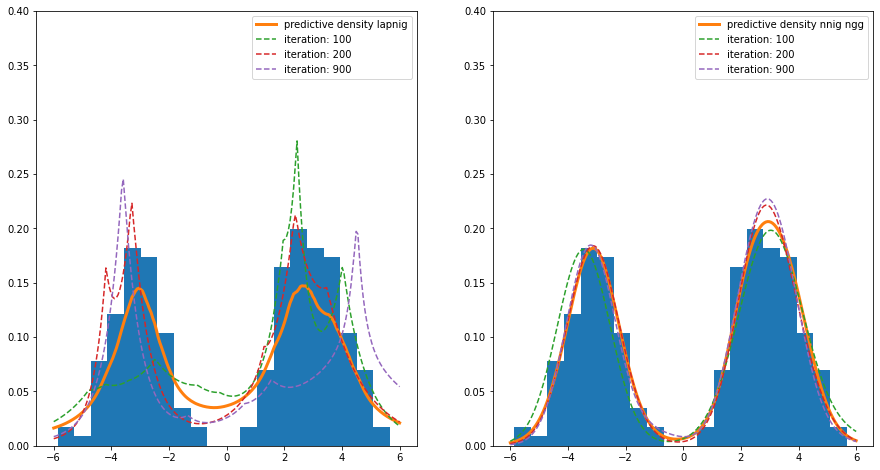

In [73]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
axes[0].set_ylim(0, 0.4)
axes[1].set_ylim(0, 0.4)
axes[0].hist(y, density=True, bins=20)
axes[0].plot(grid, np.mean(densities_lapnig, axis=0), lw=3, label="predictive density lapnig")
axes[1].hist(y, density=True, bins=20)
axes[1].plot(grid, np.mean(densities_nnig_ngg, axis=0), lw=3, label="predictive density nnig ngg")
idxs = [int((niter - nburn) * 0.1), int((niter - nburn) * 0.2), int((niter - nburn) * 0.9)]
for idx in idxs:
    axes[0].plot(grid, densities_lapnig[idx, :], "--", label="iteration: {0}".format(idx))
    axes[1].plot(grid, densities_nnig_ngg[idx, :], "--", label="iteration: {0}".format(idx))
axes[0].legend()
axes[1].legend()
plt.show()